## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
from random import sample
from IPython.display import clear_output
from pprint import pprint
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import string
import os

Comment: the built models can work with both datasets

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

text = [x.lower() for x in text]
text = ''.join(text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

--2021-12-20 03:36:25--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2021-12-20 03:36:25 (5.56 MB/s) - ‘sonnets.txt’ saved [119748/119748]

OK!


### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

text = [x.lower() for x in text]
text = ''.join(text)

--2021-12-20 05:35:40--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.4’

onegin.txt.4        100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2021-12-20 05:35:40 (11.0 MB/s) - ‘onegin.txt.4’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [3]:
tokens = sorted(set(text))
tokens.append('|')

token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

def to_matrix(data, max_len=None, pad=token_to_idx['|'], dtype='int32', batch_first = True):

    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + pad

    for i in range(len(data)):
        line_ix = [token_to_idx[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        data_ix = np.transpose(data_ix)

    return data_ix

train_dataset = []
for x in text.split('\n'):
  if len(x) > 10:
    train_dataset.append(x)

print(f'Size of train dataset: {len(train_dataset)} \n')

print('\n'.join(train_dataset[:5]))
print(to_matrix(train_dataset[:5]))

Size of train dataset: 5254 

«мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог.
его пример другим наука;
[[43 57 59 54  1 49 76 49 76  1 62 45 57 72 66  1 68 50 62 63 58 72 66  1
  60 61 45 47 53 56  5]
 [55 59 48 49 45  1 58 50  1 47  1 69 64 63 55 64  1 52 45 58 50 57 59 48
   5 83 83 83 83 83 83]
 [59 58  1 64 47 45 51 45 63 73  1 62 50 46 76  1 52 45 62 63 45 47 53 56
  83 83 83 83 83 83 83]
 [53  1 56 64 68 69 50  1 47 72 49 64 57 45 63 73  1 58 50  1 57 59 48  7
  83 83 83 83 83 83 83]
 [50 48 59  1 60 61 53 57 50 61  1 49 61 64 48 53 57  1 58 45 64 55 45 13
  83 83 83 83 83 83 83]]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [4]:
class CharRNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=256):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.num_tokens = num_tokens
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

    def rnn_loop(self, batch_ix):
        batch_size, max_length = batch_ix.size()
        hid_state = self.initial_state(batch_size)
        logprobs = []

        for x_t in batch_ix.transpose(0,1):
            hid_state, logp_next = self.forward(x_t, hid_state)
            logprobs.append(logp_next)
        
        return torch.stack(logprobs, dim=1)

    def fit(self, train_dataset, num_iter=1000, plot_loss=False):
        self.MAX_LENGTH = max(map(len, train_dataset))
        opt = torch.optim.Adam(self.parameters())
        history = []

        for i in range(num_iter):
            batch_ix = to_matrix(sample(train_dataset, 32), max_len=self.MAX_LENGTH)
            batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
            
            logp_seq = self.rnn_loop(batch_ix)
            
            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = batch_ix[:, 1:]

            loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if plot_loss:
              history.append(loss.data.numpy())
              if (i+1)%(num_iter//100)==0:
                  clear_output(True)
                  plt.plot(history,label='loss')
                  plt.title('Fit CharRNNCell')
                  plt.legend()
                  plt.show()
                  print(f'loss: {loss.data.numpy()}')

    def generate_sample(self, seed_phrase=' ', max_length=None, temperature=1.0):
        assert self.MAX_LENGTH, "You should fit model before generate sample"
        max_length = max_length if max_length else self.MAX_LENGTH

        x_sequence = [token_to_idx[token.lower()] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        hid_state = self.initial_state(batch_size=1)
        
        for i in range(len(seed_phrase) - 1):
            hid_state, _ = self.forward(x_sequence[:, i], hid_state)

        for _ in range(max_length - len(seed_phrase)):
            hid_state, logp_next = self.forward(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

            next_ix = np.random.choice(self.num_tokens, p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
            
        return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]]).split('|')[0]

Plot the loss function (axis X: number of epochs, axis Y: loss function).

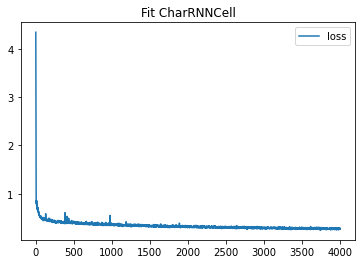

loss: 0.26812446117401123


In [5]:
char_rnn_cell = CharRNNCell()
char_rnn_cell.fit(train_dataset, num_iter=4000, plot_loss=True)

In [6]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print(f"temperature = {t}:")
  for _ in range(3):
    print('\t', char_rnn_cell.generate_sample(temperature=t))

temperature = 0.1:
	  такой в сада молодой,
	  нет был первый картиной страда,
	  него не нас очень мил.
temperature = 0.2:
	  нет часто в саду полной
	  не вот он очень меж терев,
	  невольно в перед ней нежной
temperature = 0.5:
	  это бы в первых муж тот;
	  татьяна в первый разделой
	  вердечно, в как сердца порадей
temperature = 1.0:
	  ней печалье напевет —
	  жесно высогою муток.
	  бегот жажен разврагем:
temperature = 2.0:
	  пчет бщаям; трифлуедезгу.
	  оро ввал, сей, скровопотные,:
	  фмилечкй, ннзиглихом еmу.),


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [7]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.MAX_LENGTH = None
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.rnn_num_units = rnn_num_units
        
    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def fit(self, train_dataset, num_iter=1000, plot_loss=False):
        self.MAX_LENGTH = max(map(len, train_dataset))
        opt = torch.optim.Adam(self.parameters())
        history = []

        for i in range(num_iter):
            batch_ix = to_matrix(sample(train_dataset, 32), max_len=self.MAX_LENGTH)
            batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
            
            logp_seq = self.forward(batch_ix)
            
            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = batch_ix[:, 1:]

            loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            history.append(loss.data.numpy())
            if plot_loss:
              if (i+1)%(num_iter//100)==0:
                  clear_output(True)
                  plt.plot(history,label='loss')
                  plt.title('Fit CharRNNLoop')
                  plt.legend()
                  plt.show()
                  print(f'loss: {loss.data.numpy()}')

    def generate_sample(self, seed_phrase=' ', max_length=None, temperature=1.0):
        assert self.MAX_LENGTH, "You should fit model before generate sample"
        max_length = max_length if max_length else self.MAX_LENGTH

        x_sequence = [token_to_idx[token.lower()] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        
        logp_next = self.forward(x_sequence[:, :len(seed_phrase)])

        for _ in range(max_length - len(seed_phrase)):
            logp_next = self.forward(x_sequence[:, :])
            p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
            next_ix = np.random.choice(self.num_tokens, p=p_next[-1, :])
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
            
        return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]]).split('|')[0]

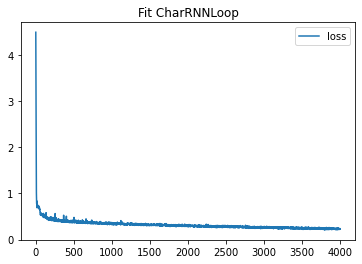

loss: 0.22776798903942108


In [8]:
char_rnn_loop = CharRNNLoop()
char_rnn_loop.fit(train_dataset, num_iter=4000, plot_loss=True)

Answer: Yes, loss become better (Cell ~ 0.27, Loop ~ 0.23)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [9]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print(f"temperature = {t}:")
  for _ in range(3):
    print('\t', char_rnn_loop.generate_sample(temperature=t))

temperature = 0.1:
	  не так ли было, и все грустья,
	  не потомушным обезами,
	  не так и страсть и под ней поря,
temperature = 0.2:
	  не там в гором он всегда сон,
	  не простой и в самом душей.
	  не постели в том не видит;
temperature = 0.5:
	  но нашей столь ее разговой,
	  страшной кажете не замети,
	  любви дели дом не открылась:
temperature = 1.0:
	  не скучал тишин чисть прелест,
	  bсидет она всё гостей поткой
	  усоб вер, не она с блестит.
temperature = 2.0:
	  оглпет. хокшу-he
	  .rz
ымец ищумни, сросце.
	  чарой пусдивцомых с»льi?.


Answer: the lower the temperature, the more the model generates popular combinations of symbols. The higher the temperature, the more diverse characters are selected, but the text turns out to be less meaningful. The ideal temperature is around 0.5

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [10]:
torch.save(char_rnn_loop, 'model')
model = torch.load('model')
model.generate_sample(temperature=0.5)

' но тайный все умеренный'

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)